In [2]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import astropy.units as u
from galpy.potential import MWPotential2014, vcirc
from scipy.stats import ks_2samp

Exponential disk (thin disk)

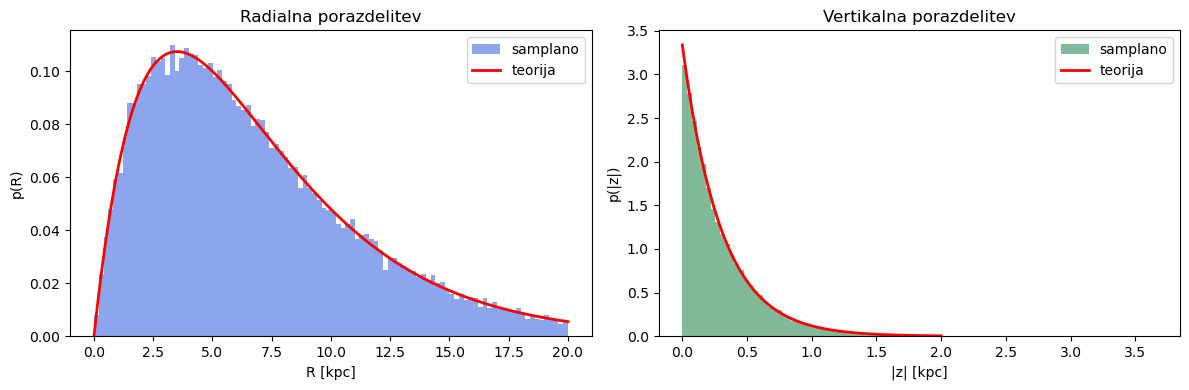

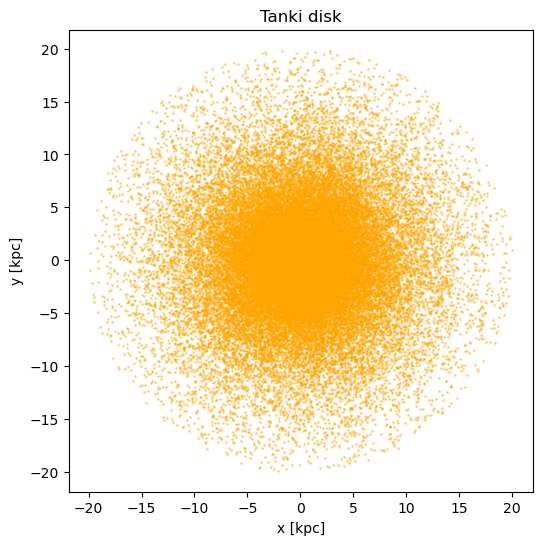

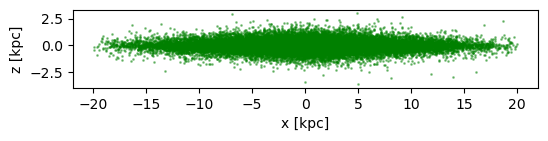

In [5]:
def sample_exponential_disk(N, lR, lz, Rmax=None):
    """
    Generate positions (R, φ, z) from a double-exponential disk density:
    ρ(R,z) ∝ exp(-R/lR) * exp(-|z|/lz)

    Parameters
    ----------
    N : int
        Number of stars to sample
    lR : Quantity
        Radial scale length (e.g. 3.5 * u.kpc)
    lz : Quantity
        Vertical scale height (e.g. 0.3 * u.kpc)
    Rmax : Quantity or None
        Optional maximum radius cutoff (e.g. 15 * u.kpc)

    Returns
    -------
    R, phi, z : Quantity arrays
    """

    R = np.random.gamma(shape=2.0, scale=lR.value, size=N) * lR.unit
    z = np.random.choice([-1, 1], size=N) * np.random.exponential(lz.value, size=N) * lz.unit
    phi = np.random.uniform(0, 2*np.pi, size=N) * u.rad

    if Rmax is not None:
        mask = R < Rmax
        R, z, phi = R[mask], z[mask], phi[mask]

    return R, phi, z


# Example usage: thin disk
N = 50000
lR_thin = 3.5 * u.kpc
lz_thin = 0.3 * u.kpc
Rmax=20

R, phi, z = sample_exponential_disk(N, lR_thin, lz_thin, Rmax=Rmax*u.kpc)

# Convert to Cartesian
x = R * np.cos(phi)
y = R * np.sin(phi)

# Check that the distributions look right
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Radial histogram
axs[0].hist(R.value, bins=100, density=True, alpha=0.6, color='royalblue', label='samplano')
Rgrid = np.linspace(0, Rmax, 400)
pdf_R = (Rgrid / lR_thin.value**2) * np.exp(-Rgrid / lR_thin.value)
axs[0].plot(Rgrid, pdf_R / np.trapz(pdf_R, Rgrid), 'r', lw=2, label='teorija')
axs[0].set_xlabel("R [kpc]"); axs[0].set_ylabel("p(R)")
axs[0].legend(); axs[0].set_title("Radialna porazdelitev")

# Vertical histogram
zabs = np.abs(z.value)
axs[1].hist(zabs, bins=100, density=True, alpha=0.6, color='seagreen', label='samplano')
zgrid = np.linspace(0, 2, 400)
pdf_z = (1/lz_thin.value) * np.exp(-zgrid/lz_thin.value)
axs[1].plot(zgrid, pdf_z / np.trapz(pdf_z, zgrid), 'r', lw=2, label='teorija')
axs[1].set_xlabel("|z| [kpc]"); axs[1].set_ylabel("p(|z|)")
axs[1].legend(); axs[1].set_title("Vertikalna porazdelitev")

plt.tight_layout(); plt.show()



plt.figure(figsize = (6,6))
plt.title("Tanki disk")

plt.scatter(x.value, y.value, s=1, alpha=0.4, color='orange')
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.gca().set_aspect('equal', 'box')

plt.figure(figsize = (6,6))
plt.scatter(x.value, z.value, s=1, alpha=0.4, color='green')
plt.xlabel("x [kpc]")
plt.ylabel("z [kpc]")
plt.gca().set_aspect('equal', 'box')
plt.show()

Thick disk distribution

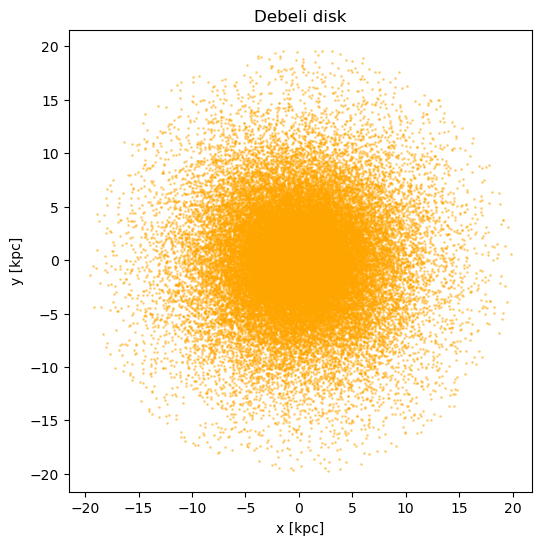

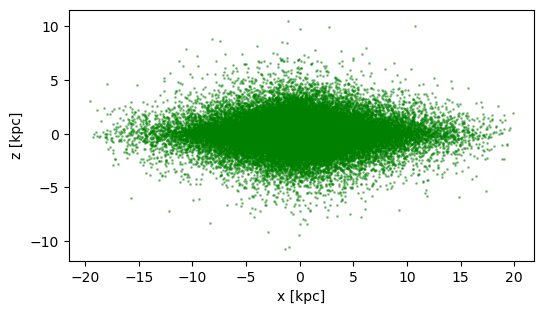

In [5]:
N = 50000  # number of stars

# Parameters from assignment
lR_thick = 2.9 * u.kpc
lz_thick = 1.0 * u.kpc
sigma_thick = 55 * u.km/u.s
ro = 8.0 * u.kpc
vo = 220.0 * u.km/u.s
Rmax = 20

# Generate spatial positions
R, phi, z = sample_exponential_disk(N, lR_thick, lz_thick, Rmax=Rmax*u.kpc)

# Compute circular velocities at each R
vc = np.array([vcirc(MWPotential2014, (Ri/ro).value) for Ri in R]) * vo

# Sample velocity components
#    Gaussian scatter around mean circular motion
vR = np.random.normal(0, sigma_thick.value, len(R)) * u.km/u.s
vT = np.random.normal(vc.value, sigma_thick.value, len(R)) * u.km/u.s
vz = np.random.normal(0, sigma_thick.value, len(R)) * u.km/u.s

# Convert to Cartesian coordinates
x = R * np.cos(phi)
y = R * np.sin(phi)


# Quick visualization
plt.figure(figsize=(6,6))
plt.scatter(x.value, y.value, s=1, alpha=0.4, color='orange')
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.gca().set_aspect('equal', 'box')
plt.title("Debeli disk")
plt.show()

# Vertical distribution check
plt.figure(figsize= (6,6))
plt.scatter(x.value, z.value, s=1, alpha=0.4, color='green')
plt.xlabel("x [kpc]")
plt.ylabel("z [kpc]")
plt.gca().set_aspect('equal', 'box')
#plt.title("Debeli disk Star Positions")
plt.show()

Halo and bulge

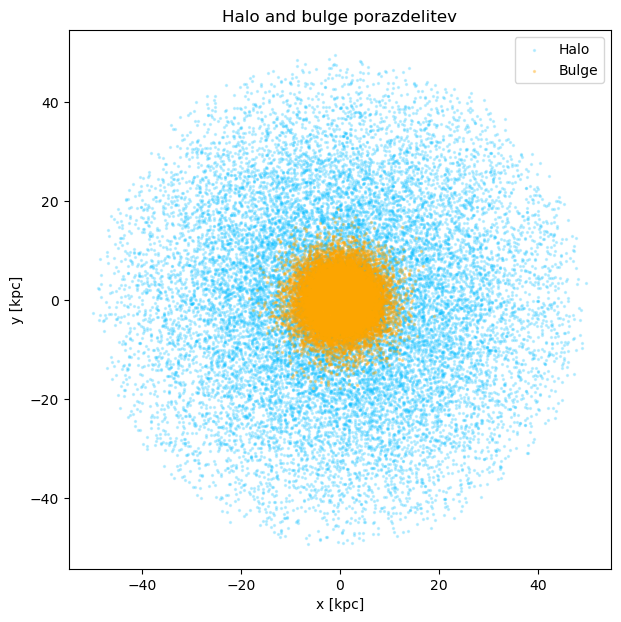

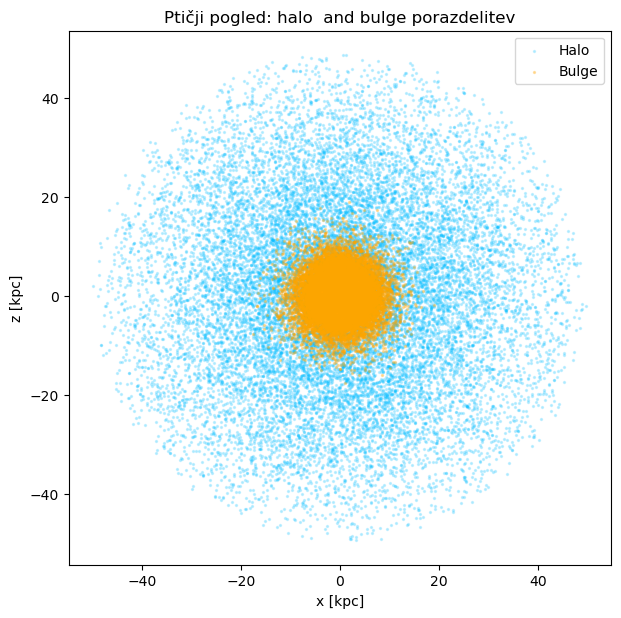

In [4]:
def sample_spherical_component(N, lR, Rmax=None):
    """
    Sample a spherical component with ρ ∝ exp(-R/lR)

    Parameters
    ----------
    N : int
        Number of stars
    lR : Quantity
        Radial scale length (e.g. 1.8 * u.kpc)
    Rmax : Quantity or None
        Optional cutoff radius

    Returns
    -------
    x, y, z : Quantity arrays
    """
    # Sample radius ~ R^2 e^{-R/lR}
    R = np.random.gamma(shape=3.0, scale=lR.value, size=N) * lR.unit
    if Rmax is not None:
        mask = R < Rmax
        R = R[mask]

    # Random direction on a sphere
    phi = np.random.uniform(0, 2*np.pi, len(R))
    cos_theta = np.random.uniform(-1, 1, len(R))
    sin_theta = np.sqrt(1 - cos_theta**2)

    # Convert to Cartesian coordinates
    x = R * sin_theta * np.cos(phi)
    y = R * sin_theta * np.sin(phi)
    z = R * cos_theta

    return x, y, z

# -----------------------------
# Bulge and Halo parameters
# -----------------------------
lR_bulge = 1.8 * u.kpc
lR_halo  = 15.0 * u.kpc

N_bulge = 30000
N_halo  = 30000

# Generate both components
x_b, y_b, z_b = sample_spherical_component(N_bulge, lR_bulge, Rmax=20*u.kpc)
x_h, y_h, z_h = sample_spherical_component(N_halo,  lR_halo,  Rmax=50*u.kpc)

# -----------------------------
# 2D projection (top-down view)
# -----------------------------
plt.figure(figsize=(7,7))
plt.scatter(x_h.value, y_h.value, s=2, alpha=0.2, color='deepskyblue', label='Halo')
plt.scatter(x_b.value, y_b.value, s=2, alpha=0.3, color='orange', label='Bulge')
plt.xlabel('x [kpc]'); plt.ylabel('y [kpc]')
plt.title('Halo and bulge porazdelitev')
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.show()

# -----------------------------
# Side view (x–z plane)
# -----------------------------
plt.figure(figsize=(7,7))
plt.scatter(x_h.value, z_h.value, s=2, alpha=0.2, color='deepskyblue', label='Halo')
plt.scatter(x_b.value, z_b.value, s=2, alpha=0.3, color='orange', label='Bulge')
plt.xlabel('x [kpc]'); plt.ylabel('z [kpc]')
plt.title('Ptičji pogled: halo  and bulge porazdelitev')
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.show()


In [27]:
def load_orbits(filename):
    data = np.loadtxt(filename, skiprows=1)
    x_i, y_i, z_i, vx_i, vy_i, vz_i, x_f, y_f, z_f, vx_f, vy_f, vz_f = data.T
    return x_i, y_i, z_i, vx_i, vy_i, vz_i, x_f, y_f, z_f, vx_f, vy_f, vz_f

# --------------------------------------------
# Physics helpers
# --------------------------------------------
def cylindrical_components(x, y, z, vx, vy, vz):
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    vR = vx * np.cos(phi) + vy * np.sin(phi)
    vT = -vx * np.sin(phi) + vy * np.cos(phi)
    return R, np.abs(z), vR, vT, vz

def orbital_energy(vx, vy, vz):
    return 0.5 * (vx**2 + vy**2 + vz**2)

# --------------------------------------------
# Statistical comparison function
# --------------------------------------------
def stability_tests(component_name, filename):
    x_i, y_i, z_i, vx_i, vy_i, vz_i, x_f, y_f, z_f, vx_f, vy_f, vz_f = load_orbits(filename)
    
    R_i, zabs_i, vR_i, vT_i, vz_i = cylindrical_components(x_i, y_i, z_i, vx_i, vy_i, vz_i)
    R_f, zabs_f, vR_f, vT_f, vz_f = cylindrical_components(x_f, y_f, z_f, vx_f, vy_f, vz_f)
    
    E_i = orbital_energy(vx_i, vy_i, vz_i)
    E_f = orbital_energy(vx_f, vy_f, vz_f)
    Lz_i = R_i * vT_i
    Lz_f = R_f * vT_f

    # Basic statistics
    delta_R = np.mean(R_f - R_i)
    delta_z = np.mean(zabs_f - zabs_i)
    delta_E = np.nanmean(np.abs((E_f - E_i) / E_i))
    delta_Lz = np.nanmean(np.abs((Lz_f - Lz_i) / Lz_i))
    
    # Kolmogorov–Smirnov tests
    ks_R = ks_2samp(R_i, R_f).pvalue
    ks_z = ks_2samp(zabs_i, zabs_f).pvalue
    ks_vR = ks_2samp(vR_i, vR_f).pvalue
    ks_vz = ks_2samp(vz_i, vz_f).pvalue

    print(f"========== {component_name.upper()} ==========")
    print(f"⟨ΔR⟩ = {delta_R:.4f} kpc")
    print(f"⟨Δ|z|⟩ = {delta_z:.4f} kpc")
    print(f"⟨|ΔE/E|⟩ = {delta_E:.4e}")
    print(f"⟨|ΔLz/Lz|⟩ = {delta_Lz:.4e}")
    print(f"KS p-values:")
    print(f"  R: {ks_R:.3f}, |z|: {ks_z:.3f}, vR: {ks_vR:.3f}, vz: {ks_vz:.3f}")
    
    # --- Quick diagnostic plots ---
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].scatter(E_i, E_f, s=1, alpha=0.3)
    axs[0].plot([E_i.min(), E_i.max()], [E_i.min(), E_i.max()], 'r--')
    axs[0].set_xlabel(r"$E_{začetni}$"); axs[0].set_ylabel(r"$E_{končni}$")
    axs[0].set_title(f"{component_name}: Ohrtanitev energije")

    axs[1].scatter(Lz_i, Lz_f, s=1, alpha=0.3, color='orange')
    axs[1].plot([Lz_i.min(), Lz_i.max()], [Lz_i.min(), Lz_i.max()], 'r--')
    axs[1].set_xlabel(r"$Lz_{začetni}$"); axs[1].set_ylabel(r"$Lz_{končni}$")
    axs[1].set_title(f"{component_name}: Ohranjanje vrtilne količine")

    plt.tight_layout()
    plt.show()

========== TANKI DISK ==========
⟨ΔR⟩ = 4.6141 kpc
⟨Δ|z|⟩ = -0.0144 kpc
⟨|ΔE/E|⟩ = 2.2747e-01
⟨|ΔLz/Lz|⟩ = 1.6240e-08
KS p-values:
  R: 0.164, |z|: 0.219, vR: 0.370, vz: 0.000


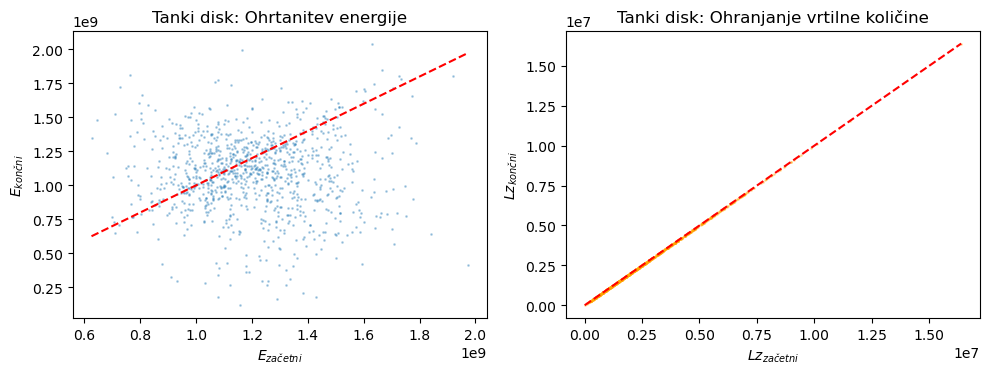

========== DEBELI DISK ==========
⟨ΔR⟩ = 0.2014 kpc
⟨Δ|z|⟩ = -1.3144 kpc
⟨|ΔE/E|⟩ = 5.7232e-01
⟨|ΔLz/Lz|⟩ = 1.2907e-08
KS p-values:
  R: 0.370, |z|: 0.000, vR: 0.001, vz: 0.000


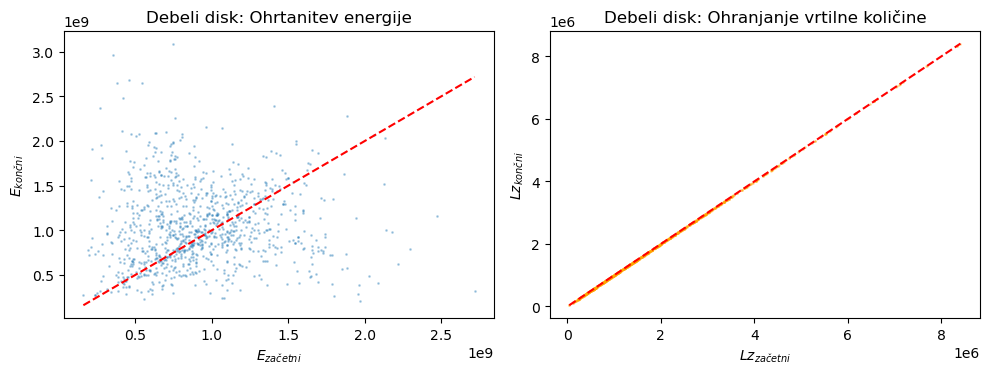

========== BULGE ==========
⟨ΔR⟩ = -3.0356 kpc
⟨Δ|z|⟩ = -2.4799 kpc
⟨|ΔE/E|⟩ = 4.0323e+00
⟨|ΔLz/Lz|⟩ = 1.6750e-07
KS p-values:
  R: 0.000, |z|: 0.000, vR: 0.002, vz: 0.000


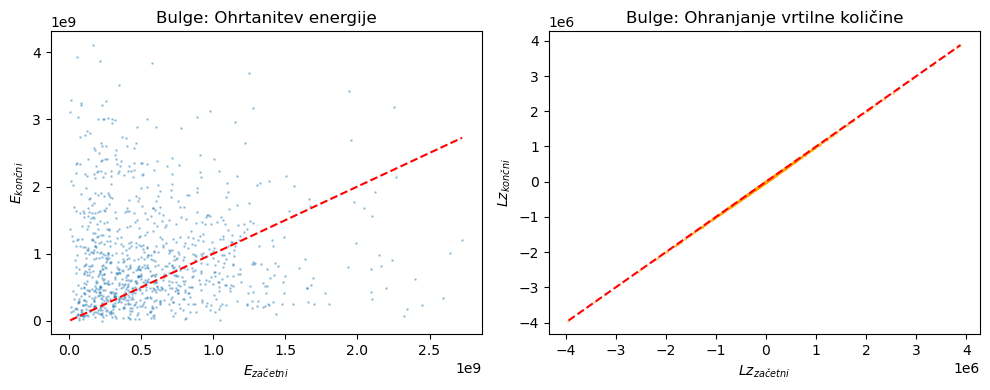

========== HALO ==========
⟨ΔR⟩ = 201.4247 kpc
⟨Δ|z|⟩ = 126.2511 kpc
⟨|ΔE/E|⟩ = 2.1577e+00
⟨|ΔLz/Lz|⟩ = 2.3756e-08
KS p-values:
  R: 0.000, |z|: 0.000, vR: 0.000, vz: 0.000


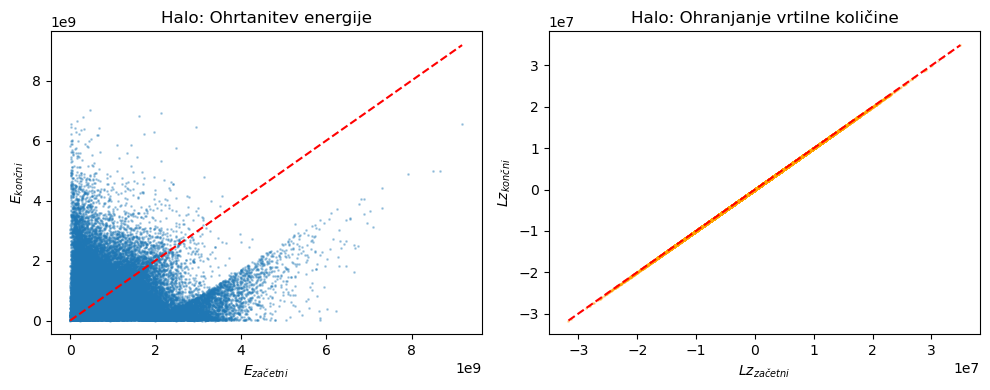

In [28]:
stability_tests("Tanki disk", "orbits_thin.txt")
stability_tests("Debeli disk", "orbits_thick.txt")
stability_tests("Bulge", "orbits_bulge.txt")
stability_tests("Halo", "orbits_halo.txt")

In [16]:
def compare_distributions(component, filename, bins_R=40, bins_z=40, bins_v=50):
    data = np.loadtxt(filename, skiprows=1)
    x_i, y_i, z_i, vx_i, vy_i, vz_i, x_f, y_f, z_f, vx_f, vy_f, vz_f = data.T

    # Cylindrical coordinates
    R_i = np.sqrt(x_i**2 + y_i**2)
    R_f = np.sqrt(x_f**2 + y_f**2)
    zabs_i = np.abs(z_i)
    zabs_f = np.abs(z_f)
    
    phi_i = np.arctan2(y_i, x_i)
    phi_f = np.arctan2(y_f, x_f)
    
    vR_i = vx_i * np.cos(phi_i) + vy_i * np.sin(phi_i)
    vR_f = vx_f * np.cos(phi_f) + vy_f * np.sin(phi_f)
    vT_i = -vx_i * np.sin(phi_i) + vy_i * np.cos(phi_i)
    vT_f = -vx_f * np.sin(phi_f) + vy_f * np.cos(phi_f)

    # --- Plot ---
    fig, axs = plt.subplots(2, 3, figsize=(13, 7))
    axs = axs.ravel()
    fig.suptitle(f"{component}", fontsize=16)
    axs[0].hist(R_i, bins=bins_R, alpha=0.5, label='Initial', color='C0', density=True)
    axs[0].hist(R_f, bins=bins_R, alpha=0.5, label='Final', color='C3', density=True)
    axs[0].set_xlabel("R [kpc]"); axs[0].set_ylabel("Density")
    axs[0].set_title("Radialna porazdelitev")

    axs[1].hist(zabs_i, bins=bins_z, alpha=0.5, label='Initial', color='C0', density=True)
    axs[1].hist(zabs_f, bins=bins_z, alpha=0.5, label='Final', color='C3', density=True)
    axs[1].set_xlabel("|z| [kpc]")
    axs[1].set_title("Vertikalna porazdelitev")

    axs[2].hist(vR_i/1000, bins=bins_v, alpha=0.5, label='Initial', color='C0', density=True)
    axs[2].hist(vR_f/1000, bins=bins_v, alpha=0.5, label='Final', color='C3', density=True)
    axs[2].set_xlabel(r"$v_{R}$ [km/s]")
    axs[2].set_title("Radialna hitrost")

    axs[3].hist(vT_i/1000, bins=bins_v, alpha=0.5, label='Initial', color='C0', density=True)
    axs[3].hist(vT_f/1000, bins=bins_v, alpha=0.5, label='Final', color='C3', density=True)
    axs[3].set_xlabel(r"$v_{T}$ [km/s]")
    axs[3].set_title("Tangencialna hitrost")

    axs[4].hist(vz_i/1000, bins=bins_v, alpha=0.5, label='Initial', color='C0', density=True)
    axs[4].hist(vz_f/1000, bins=bins_v, alpha=0.5, label='Final', color='C3', density=True)
    axs[4].set_xlabel(r"$v_{z}$[km/s]")
    axs[4].set_title("Vertikalna hitrost")

    axs[5].axis("off")
    axs[0].legend()

    plt.tight_layout()
    plt.show()

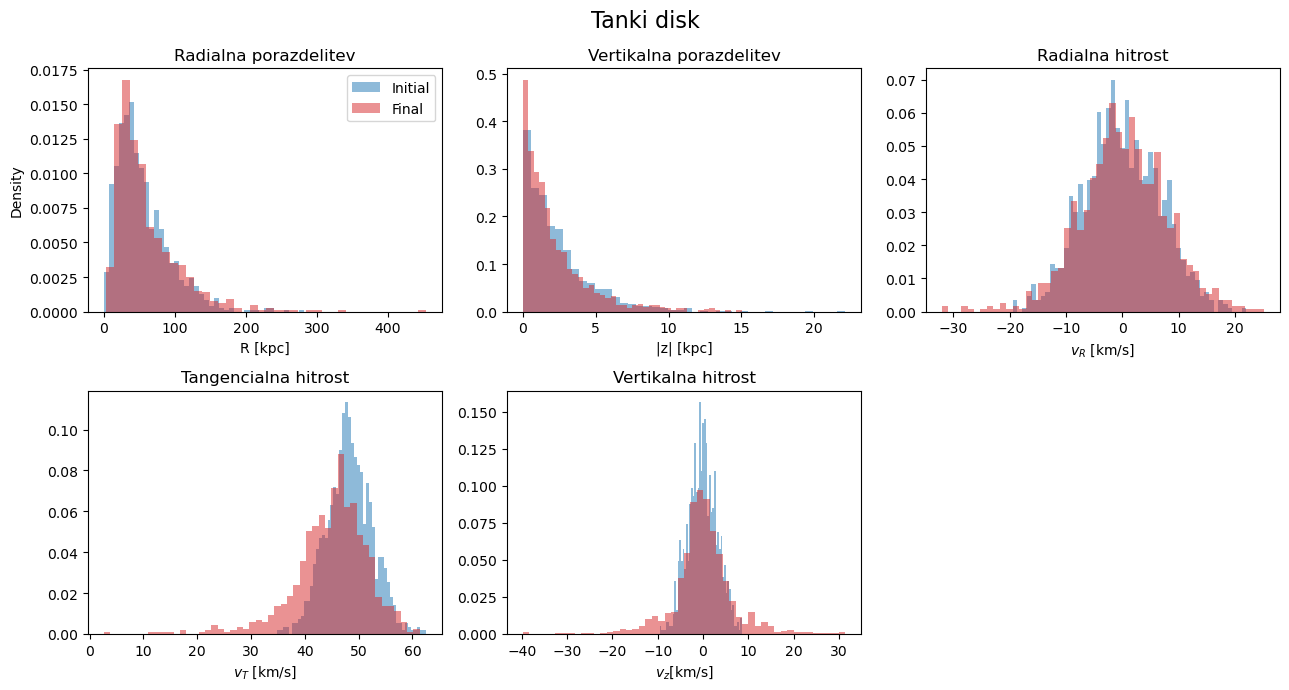

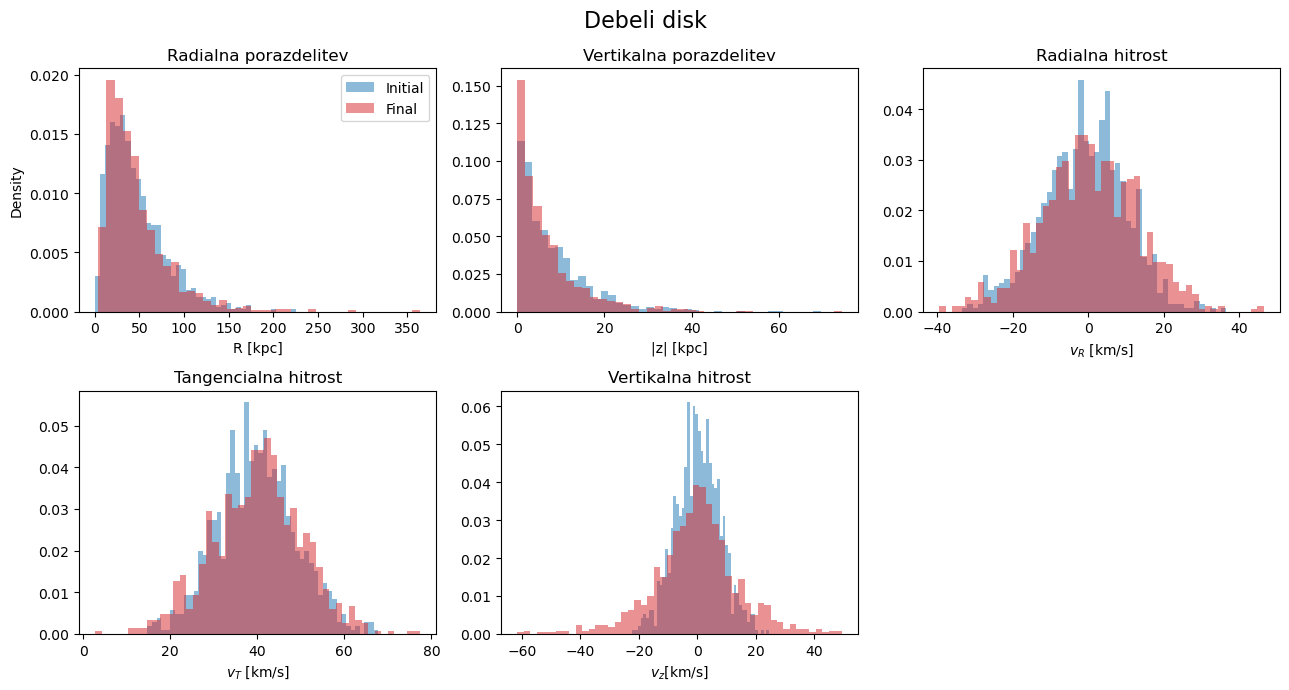

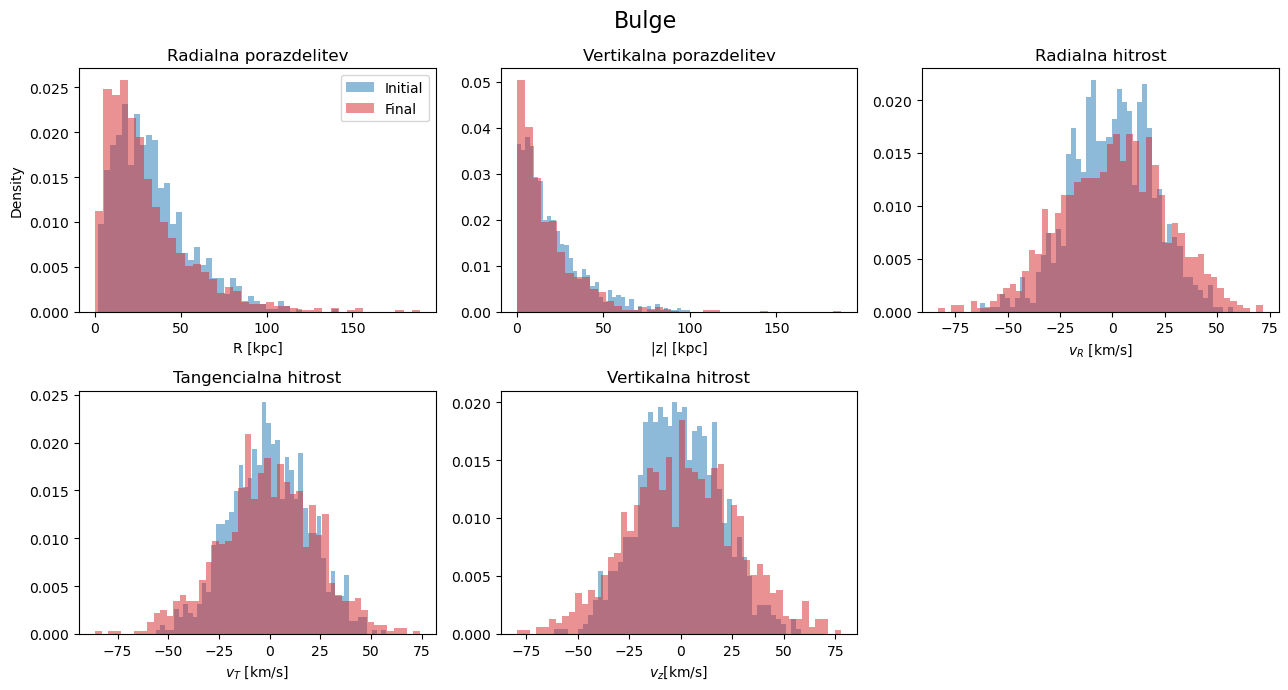

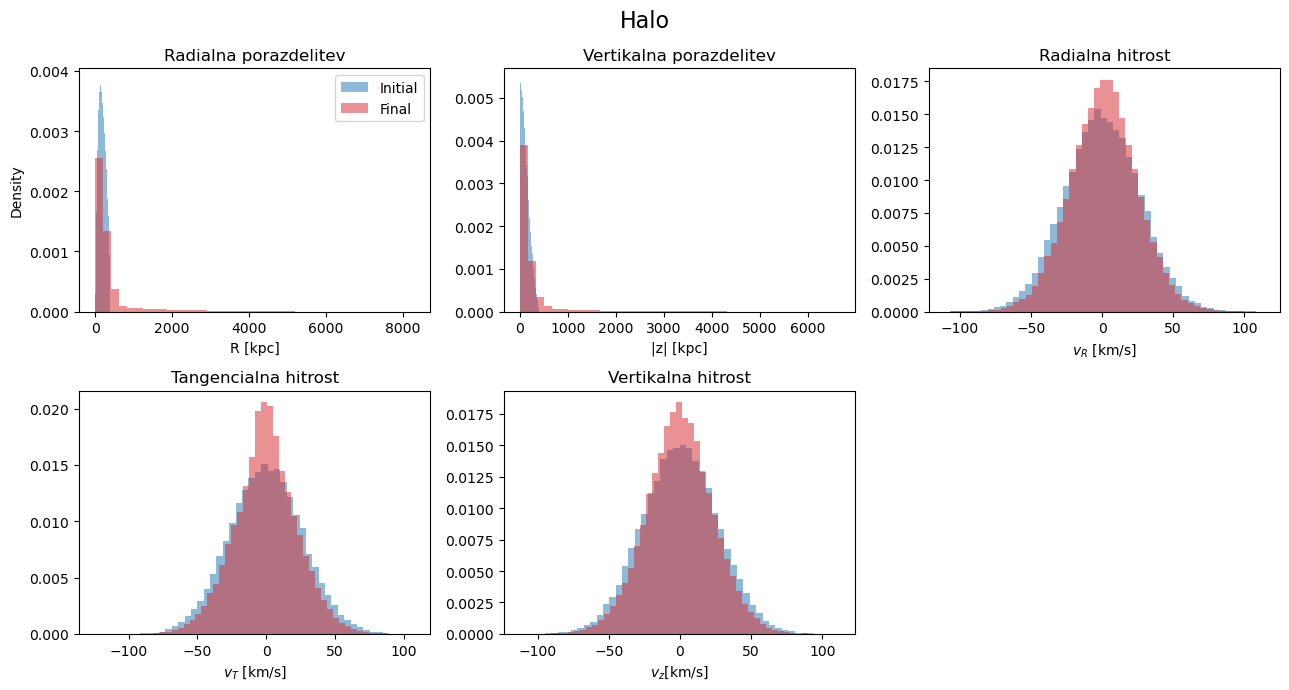

In [17]:
compare_distributions("Tanki disk", "orbits_thin.txt")
compare_distributions("Debeli disk", "orbits_thick.txt")
compare_distributions("Bulge", "orbits_bulge.txt")
compare_distributions("Halo", "orbits_halo.txt")